In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
import torch
import torchvision
from PIL import Image
import torch.nn as nn
from torchvision import transforms

In [26]:
from torchvision import models


# GAN

In [27]:
with open('/content/gdrive/MyDrive/pytorch/imagenet_classes.txt', 'r') as file:
    content = file.read()
print(content)

tench, Tinca tinca
goldfish, Carassius auratus
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
tiger shark, Galeocerdo cuvieri
hammerhead, hammerhead shark
electric ray, crampfish, numbfish, torpedo
stingray
cock
hen
ostrich, Struthio camelus
brambling, Fringilla montifringilla
goldfinch, Carduelis carduelis
house finch, linnet, Carpodacus mexicanus
junco, snowbird
indigo bunting, indigo finch, indigo bird, Passerina cyanea
robin, American robin, Turdus migratorius
bulbul
jay
magpie
chickadee
water ouzel, dipper
kite
bald eagle, American eagle, Haliaeetus leucocephalus
vulture
great grey owl, great gray owl, Strix nebulosa
European fire salamander, Salamandra salamandra
common newt, Triturus vulgaris
eft
spotted salamander, Ambystoma maculatum
axolotl, mud puppy, Ambystoma mexicanum
bullfrog, Rana catesbeiana
tree frog, tree-frog
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
loggerhead, loggerhead turtle, Caretta caretta
leatherback

In [28]:
resnet = models.resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3>

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [30]:
netG = ResNetGenerator()

In [31]:
model_path = '/content/gdrive/MyDrive/pytorch/dlwpt-code-master/data/p1ch2/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [ ]:
netG.eval()

In [33]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

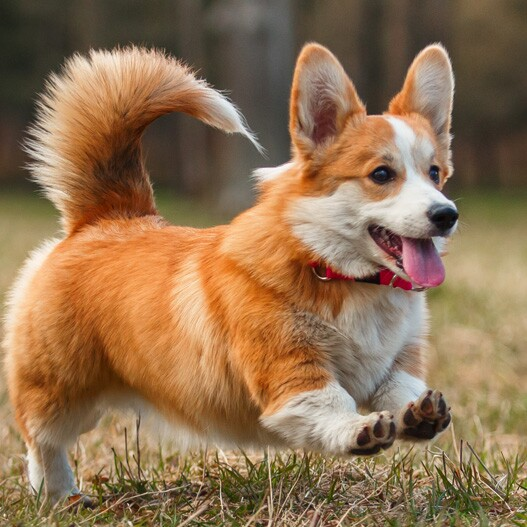

In [37]:
img = Image.open('/content/gdrive/MyDrive/pytorch/ratgeber_hund_rasse_portraits_welsh-corgi-pembroke_1200x527.jpg')
img

In [38]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)
batch_out = netG(batch_t)

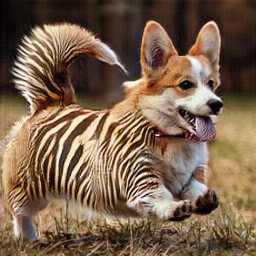

In [39]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img